In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.CIFAR10('data/train', train=True, download=True, transform=transform)
testset = datasets.CIFAR10('data/test', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [17]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    model.cuda()

epochs = 10
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

for e in range(epochs):
    running_loss = 0
    correct_train = 0
    total_train = 0
    train_accuracy_epoch = []
    
    for images, labels in trainloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        train_accuracy_epoch.append((predicted == labels).sum().item() / labels.size(0))
    
    train_loss_epoch = running_loss / len(trainloader)
    train_accuracy_epoch = sum(train_accuracy_epoch) / len(trainloader)
    
    train_losses.append(train_loss_epoch)
    train_accuracy.append(train_accuracy_epoch)

    print(f"Epoch {e+1}/{epochs}.. "
          f"Train loss: {train_loss_epoch:.3f}.. "
          f"Train accuracy: {train_accuracy_epoch:.3f}")
    
    test_loss = 0
    correct_test = 0
    total_test = 0
    test_accuracy_epoch = []
    
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()

            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy_epoch.append(torch.mean(equals.type(torch.FloatTensor)).item())

        test_loss /= len(testloader)
        test_accuracy_epoch = sum(test_accuracy_epoch) / len(testloader)

        test_losses.append(test_loss)
        test_accuracy.append(test_accuracy_epoch)

        print(f"Test loss: {test_loss:.3f}.. "
              f"Test accuracy: {test_accuracy_epoch:.3f}")





Epoch 1/10.. Train loss: 0.851.. Train accuracy: 0.705
Test loss: 0.920.. Test accuracy: 0.679
Epoch 2/10.. Train loss: 0.813.. Train accuracy: 0.717
Test loss: 1.045.. Test accuracy: 0.632
Epoch 3/10.. Train loss: 0.779.. Train accuracy: 0.729
Test loss: 0.883.. Test accuracy: 0.694
Epoch 4/10.. Train loss: 0.740.. Train accuracy: 0.743
Test loss: 0.992.. Test accuracy: 0.652
Epoch 5/10.. Train loss: 0.705.. Train accuracy: 0.755
Test loss: 0.986.. Test accuracy: 0.669
Epoch 6/10.. Train loss: 0.670.. Train accuracy: 0.768
Test loss: 0.912.. Test accuracy: 0.680
Epoch 7/10.. Train loss: 0.634.. Train accuracy: 0.780
Test loss: 0.998.. Test accuracy: 0.671
Epoch 8/10.. Train loss: 0.600.. Train accuracy: 0.793
Test loss: 0.956.. Test accuracy: 0.683
Epoch 9/10.. Train loss: 0.566.. Train accuracy: 0.805
Test loss: 0.908.. Test accuracy: 0.697
Epoch 10/10.. Train loss: 0.532.. Train accuracy: 0.815
Test loss: 1.041.. Test accuracy: 0.669


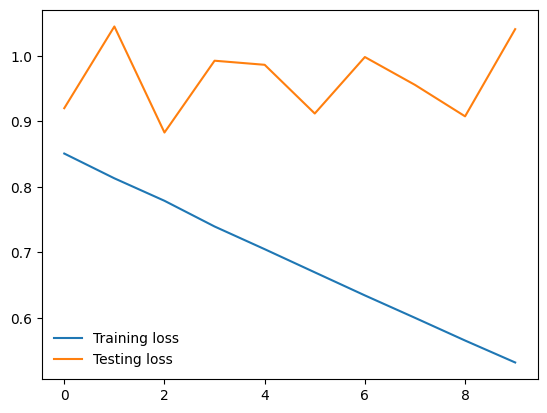

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.legend(frameon=False)
plt.show()




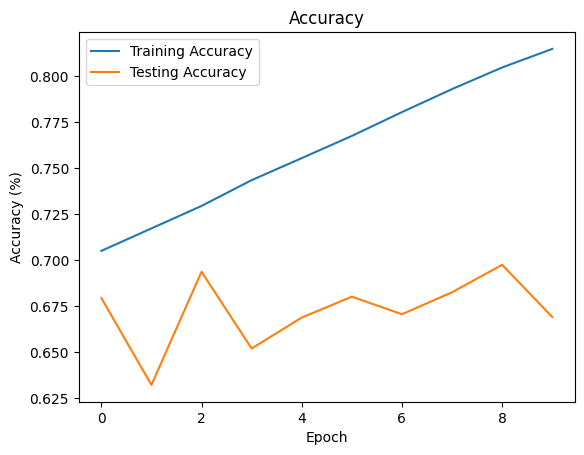

In [19]:
# Graficar la accuracy
plt.plot(train_accuracy , label='Training Accuracy')
plt.plot(test_accuracy , label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

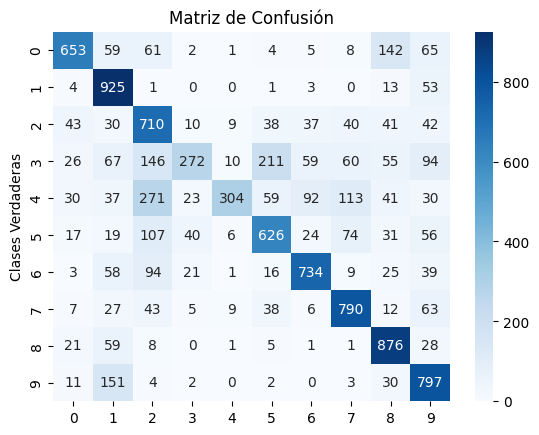

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obtener las predicciones del modelo en el conjunto de prueba
model.eval() # Asegurarse de que el modelo está en modo evaluación
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Convertir las predicciones y las etiquetas verdaderas a una lista de etiquetas numéricas
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión")
plt.ylabel("Clases Verdaderas")
plt.show()